# Time series modeling: Linear Regression and Decision Trees

Notebook to add time series variables to models using pyspark. Based on [this blog post](https://medium.com/analytics-vidhya/time-series-forecasting-using-spark-ml-part-2-31506514c643)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
cur_path = "/content/drive/My Drive/big-data-final-project/"
os.chdir(cur_path)

Mounted at /content/drive


In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import StructType, StructField, LongType

import statsmodels.tsa.stattools as ts

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# start session
spark = SparkSession.builder.master("local[5]").appName("groupbyagg").getOrCreate()

# Data

In [ ]:
data = spark.read.csv(cur_path + 'Sunspots.csv',inferSchema=True,header=True)

In [ ]:
data = data.withColumnRenamed('Monthly Mean Total Sunspot Number', 'sunspots')
data = data.select(to_date(col("date"),"yyyy-mm-dd").alias("date"), 'sunspots')
data.show(1)

+----------+--------+
|      date|sunspots|
+----------+--------+
|1749-01-31|    96.7|
+----------+--------+
only showing top 1 row



In [ ]:
data.printSchema()

root
 |-- date: date (nullable = true)
 |-- sunspots: double (nullable = true)



# Create Variables

Before running the next code, set the following variables:
* n_lags: the number of previous months to lag with
* data_lag: a new dataframe to put lagged variables in
* features: a list of the features created (for use in vectorassembler later)
* forecast_months: number of time-steps to forecast (for example, we could say 10 and get the predicted average sunspots for the next 10 months)

In [ ]:
n_lags = 5
data_lag = data.select('*')
features = ['sunspots']
forecast_months = 10

## Create lags

Create the time-lagged mean sunspot values

In [ ]:
# add col to partition by
data_lag = data_lag.withColumn("Series",lit('Univariate'))

# set up window
lag_window = Window.orderBy("Series")

for i in range(n_lags):
    str_lag = 'sunspots'+'_lag_'+str(i+1)
    data_lag = data_lag.withColumn(str_lag,
                                   lag(data_lag['sunspots'], i+1).over(lag_window))
    features.append(str_lag)
    
data_lag = data_lag.drop('Series')    
data_lag.show(5)

+----------+--------+--------------+--------------+--------------+--------------+--------------+
|      date|sunspots|sunspots_lag_1|sunspots_lag_2|sunspots_lag_3|sunspots_lag_4|sunspots_lag_5|
+----------+--------+--------------+--------------+--------------+--------------+--------------+
|1749-01-31|    96.7|          null|          null|          null|          null|          null|
|1749-01-28|   104.3|          96.7|          null|          null|          null|          null|
|1749-01-31|   116.7|         104.3|          96.7|          null|          null|          null|
|1749-01-30|    92.8|         116.7|         104.3|          96.7|          null|          null|
|1749-01-31|   141.7|          92.8|         116.7|         104.3|          96.7|          null|
+----------+--------+--------------+--------------+--------------+--------------+--------------+
only showing top 5 rows



## Moving average over lag window

In [ ]:
mavg_window = Window.rowsBetween(-n_lags, 0)
str_mov_avg = 'sunspots'+'_' + str(n_lags)+'_moving_avg'
data_lag = data_lag.withColumn(str_mov_avg, avg(data_lag['sunspots']).over(mavg_window))
features.append(str_mov_avg)
data_lag.show(5)

+----------+--------+--------------+--------------+--------------+--------------+--------------+---------------------+
|      date|sunspots|sunspots_lag_1|sunspots_lag_2|sunspots_lag_3|sunspots_lag_4|sunspots_lag_5|sunspots_5_moving_avg|
+----------+--------+--------------+--------------+--------------+--------------+--------------+---------------------+
|1749-01-31|    96.7|          null|          null|          null|          null|          null|                 96.7|
|1749-01-28|   104.3|          96.7|          null|          null|          null|          null|                100.5|
|1749-01-31|   116.7|         104.3|          96.7|          null|          null|          null|   105.89999999999999|
|1749-01-30|    92.8|         116.7|         104.3|          96.7|          null|          null|              102.625|
|1749-01-31|   141.7|          92.8|         116.7|         104.3|          96.7|          null|   110.44000000000001|
+----------+--------+--------------+------------

## Time Series Trends

How do sunspots change from one month to the next? Use this sign variable to find out

In [ ]:
# if current sunspots > time-lagged sunspots then sign = +1.0
# if current sunspots < time-lagged sunspots then sign = -1.0
data_lag = data_lag.withColumn("Series",lit('Univariate'))       
trend_window = Window.orderBy("Series")
for i in range(n_lags):
    str_sign = 'sunspots' +'_lag_'+str(i+1)+'_sign'
    data_lag = data_lag.withColumn(str_sign,\
                        signum((data_lag['sunspots'] - lag(data_lag['sunspots'],i+1).over(trend_window))))
    features.append(str_sign)

data_lag = data_lag.drop("Series")

data_lag.show(5)

+----------+--------+--------------+--------------+--------------+--------------+--------------+---------------------+-------------------+-------------------+-------------------+-------------------+-------------------+
|      date|sunspots|sunspots_lag_1|sunspots_lag_2|sunspots_lag_3|sunspots_lag_4|sunspots_lag_5|sunspots_5_moving_avg|sunspots_lag_1_sign|sunspots_lag_2_sign|sunspots_lag_3_sign|sunspots_lag_4_sign|sunspots_lag_5_sign|
+----------+--------+--------------+--------------+--------------+--------------+--------------+---------------------+-------------------+-------------------+-------------------+-------------------+-------------------+
|1749-01-31|    96.7|          null|          null|          null|          null|          null|                 96.7|               null|               null|               null|               null|               null|
|1749-01-28|   104.3|          96.7|          null|          null|          null|          null|                100.5|      

## Put all above data manipulations into one function

In [ ]:
def create_ts_vars(data, n_lags, features):

  ## LAG VARS ######################################################################
  # add col to partition by
  data = data.withColumn("Series",lit('Univariate'))

  # set up window
  lag_window = Window.orderBy("Series")

  for i in range(n_lags):
      str_lag = 'sunspots'+'_lag_'+str(i+1)
      data = data.withColumn(str_lag, lag(data['sunspots'], i+1).over(lag_window))
      features.append(str_lag)
      
  data = data.drop('Series')   

  ## MOVING AVG VAR ##############################################################
  mavg_window = Window.rowsBetween(-n_lags, 0)
  str_mov_avg = 'sunspots'+'_' + str(n_lags)+'_moving_avg'
  data = data.withColumn(str_mov_avg, avg(data['sunspots']).over(mavg_window))
  features.append(str_mov_avg)

  ## TREND VAR ###################################################################
  # if current sunspots > time-lagged sunspots then sign = +1.0
  # if current sunspots < time-lagged sunspots then sign = -1.0
  data = data.withColumn("Series",lit('Univariate'))       
  trend_window = Window.orderBy("Series")
  for i in range(n_lags):
      str_sign = 'sunspots' +'_lag_'+str(i+1)+'_sign'
      data = data.withColumn(str_sign,\
                          signum((data['sunspots'] - lag(data['sunspots'],i+1).over(trend_window))))
      features.append(str_sign)
      
  data = data.drop("Series")
  
  return(data)

## Train/Test Split

In [ ]:
def split_time_series(data, train_ratio=0.7):
     
    # split data into train and test but maintain time-order
    newSchema  = StructType(data.schema.fields + \
                [StructField('Row Number', LongType(), False)])
    new_rdd = data.rdd.zipWithIndex().map(lambda x: list(x[0]) + [x[1]])

    # create new df with row number
    new_df = spark.createDataFrame(new_rdd, newSchema)
    total_rows = new_df.count()
    splitFraction  =int(total_rows*train_ratio)

    df_train = new_df.where(new_df['Row Number'] >= 0)\
                   .where(new_df['Row Number'] <= splitFraction)
    df_test = new_df.where(new_df['Row Number'] > splitFraction)
    
    return df_train, df_test

## Set up data for modeling

In [ ]:
def data_for_modeling(data, forecast_months):
  # create label 
  lead_window = Window.rowsBetween(0,forecast_months)   
  data = data.withColumn("label", last(data['sunspots']).over(lead_window))
  
  # vector assembler
  data = data.dropna()
  assembler = VectorAssembler().setInputCols(features).setOutputCol("features")
  data_transformed = assembler.transform(data)

  return(data_transformed)

# Helper Functions

## Check that distribution is stationary 

In [ ]:
def CheckStationarity(timeSeriesCol):
    
    # this function works with Pandas dataframe only not with spark dataframes
    # this performs Augmented Dickey-Fuller's test
    
    test_result = ts.adfuller(timeSeriesCol.values)
    print('ADF Statistic : %f \n' %test_result[0])
    print('p-value : %f \n' %test_result[1])
    print('Critical values are: \n')
    print(test_result[4])

## Prediction

In [ ]:
def Predict(I, df1, df2, timeSeriesCol, predictionCol, joinCol):
    
    # converts differenced predictions to raw predictions
    dZCol = 'DeltaZ'+str(i) 
    f_strCol = 'forecast_'+str(i)+'day'
    df = df1.join(df2, [joinCol], how='inner').orderBy(asc('Date'))
    df = df.withColumnRenamed(predictionCol, dZCol)
    df = df.withColumn(f_strCol, col(dZCol)+col(timeSeriesCol))

    return df

## Save results for comparison

# Data for Modeling

1. Run create_ts_vars using desired variables

In [ ]:
n_lags = 12*5
data_lag = data.select('*')
features = ['sunspots']
forecast_months = 10

In [ ]:
data_lag = create_ts_vars(data_lag, n_lags, features)
data_lag.show(10)

+----------+--------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+----------------------+-----

In [ ]:
len(data_lag.columns)-1

122

2. Set up data for modeling (set up label, [features])

In [ ]:
data_transformed = data_for_modeling(data_lag, forecast_months)

3. Train-test split

In [ ]:
train, test = split_time_series(data_transformed, 0.7)

In [ ]:
print(train.count())
print(test.count())

2261
968


Now the data is ready for modeling! 

# Linear Regression

In [ ]:
def lr_fxn(train, test):
  # init model
  lr = LinearRegression(featuresCol = "features", labelCol="label", \
                                maxIter = 100, regParam = 0.4, \
                                elasticNetParam = 0.1)
  
  # fit model 
  model = lr.fit(train)
  pred_train = model.transform(train)
  pred_test = model.transform(test)
  

  # calc rmse
  evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName ="rmse")
  RMSE_train = evaluator.evaluate(pred_train)
  RMSE_test= evaluator.evaluate(pred_test)

  return train, test, pred_train, pred_test, RMSE_train, RMSE_test

In [ ]:
lr_train, lr_test, lr_pred_train, lr_pred_test, lr_RMSE_train, lr_RMSE_test = lr_fxn(train, test)

lr_pred_train.select(['date', 'label','prediction']).show(5)

+----------+-----+------------------+
|      date|label|        prediction|
+----------+-----+------------------+
|1752-01-31| 62.7|31.896350369326665|
|1752-01-29| 66.7| 35.36469983649058|
|1752-01-31| 73.3| 48.56399228673064|
|1752-01-30| 53.3| 56.77035669115952|
|1752-01-31| 76.2| 63.89659061436963|
+----------+-----+------------------+
only showing top 5 rows



In [ ]:
lr_RMSE_test

35.971695705954666

In [ ]:
lr_RMSE_train

34.57541121079317

Graph

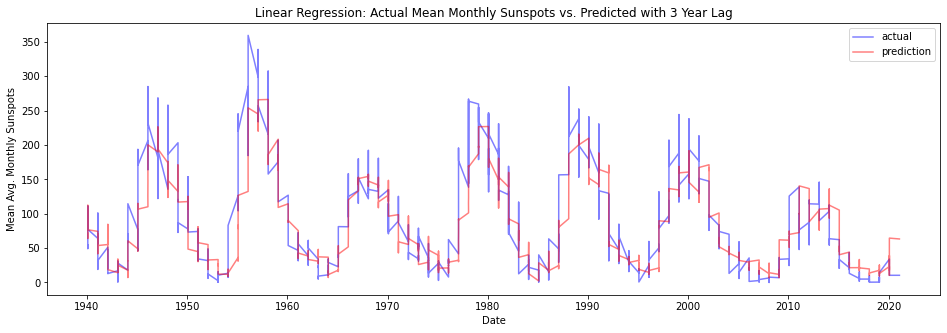

In [ ]:
# label & prediction
lr_pred_test_df = lr_pred_test.select(['date', 'label','prediction']).toPandas()

fig = plt.figure(figsize=(16,5))
plt.plot(lr_pred_test_df['date'], lr_pred_test_df['label'], color='blue', label='actual', alpha=0.5)
plt.plot(lr_pred_test_df['date'], lr_pred_test_df['prediction'], color='red', label='prediction', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Mean Avg. Monthly Sunspots')
plt.title('Linear Regression: Actual Mean Monthly Sunspots vs. Predicted with 3 Year Lag')
plt.legend(loc="upper right")

plt.show()

# Decision Tree

In [ ]:
def dt_fxn(train, test, max_depth=5):
  # init
  dt = DecisionTreeRegressor(featuresCol = "features", labelCol = "label", maxDepth = max_depth)

  # fit model & get preds
  model = dt.fit(train)
  pred_train = model.transform(train)
  pred_test = model.transform(test)
  
  # calc rmse
  evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label", metricName ="rmse")
  RMSE_train = evaluator.evaluate(pred_train)
  RMSE_test= evaluator.evaluate(pred_test)

  return train, test, pred_train, pred_test, RMSE_train, RMSE_test

In [ ]:
dt_train, dt_test, dt_pred_train, dt_pred_test, dt_RMSE_train, dt_RMSE_test = dt_fxn(train, test, max_depth=10)

dt_pred_train.select(['date', 'label','prediction']).show(5)

+----------+-----+------------------+
|      date|label|        prediction|
+----------+-----+------------------+
|1754-01-31| 22.0|13.243333333333336|
|1754-01-28|  7.0|18.022522522522525|
|1754-01-31| 17.0|18.022522522522525|
|1754-01-30| 18.7|13.243333333333336|
|1754-01-31| 11.3|13.243333333333336|
+----------+-----+------------------+
only showing top 5 rows



In [ ]:
dt_RMSE_test

45.475663194110304

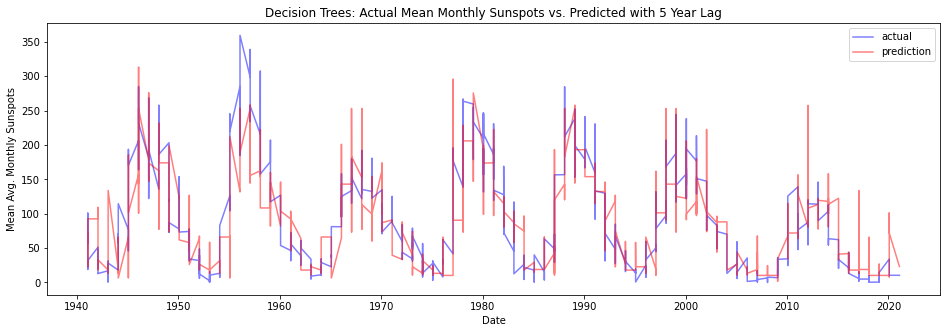

In [ ]:
# label & prediction
dt_pred_test_df = dt_pred_test.select(['date', 'label','prediction']).toPandas()

fig = plt.figure(figsize=(16,5))
plt.plot(dt_pred_test_df['date'], dt_pred_test_df['label'], color='blue', label='actual', alpha=0.5)
plt.plot(dt_pred_test_df['date'], dt_pred_test_df['prediction'], color='red', label='prediction', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Mean Avg. Monthly Sunspots')
plt.title('Decision Trees: Actual Mean Monthly Sunspots vs. Predicted with 5 Year Lag')
plt.legend(loc="upper right")

plt.show()

# Forecast for Best Model

## Time Differencing

Function for first-order differencing -- creates stationary

In [ ]:
def first_order_diff(data, input_col, output_col):
    # performs first-order differencing
    lag1_window = window.Window.rowsBetween(-1, 0)
    data = data.withColumn(output_col, data[input_col] -  first(data[input_col]).over(lag1_window))
    return data

## Predictions

In [ ]:
def diffed_preds(train, test, model_type, n_lags, forecast_days, filename):
    
    # this is the main function which calls forecast and predict
    # this saves predictions in csv files
    
    # differencing data to remove non-stationarity
    train_diff = first_order_diff(train, 'sunspots', 'diff_sunspots')
    test_diff = first_order_diff(test, 'sunspots', 'diff_sunspots')
    
    RMSE_test = {}
    RMSE_train = {}
    
    # undifference data
    for i in range(1, forecast_days+1):
    
        # training with Spark's ML algorithms    
        df_test, df_train, \
        predictions_test, predictions_train,\
        RMSE_ts, RMSE_tr = \
        Forecast(df.select("Date",'sunspots', 'diff_sunspots'),i, n_lags, 'diff_sunspots',model_type)
        
        RMSE_test.update({'forecast_'+str(i)+'day':RMSE_ts})
        RMSE_train.update({'forecast_'+str(i)+'day':RMSE_tr})
    
    #predictions for training data            
        if(i == 1):
          #saving the 1-day forecast as separate column
            corr_predict_train = Predict(i, df_train.select("Row Number",
                                                                                 "Date",\
                                                                                 timeSeriesCol),\
                                                         predictions_train.select("Row Number",\
                                                                                                "prediction"),
                                                         timeSeriesCol,\
                                                         "prediction",\
                                                         "Row Number")
            
            corr_predict_test = Predict(i, \
                                                        df_test.select("Row Number",\
                                                                               "Date",\
                                                                               timeSeriesCol),\
                                                        predictions_test.select("Row Number",\
                                                                                             "prediction"),
                                                        timeSeriesCol,\
                                                       "prediction",\
                                                       "Row Number") 
        else:
            # saving each subsequent forecast as separate column
            strCol_prev= "forecast_" + str(i-1) + "day"
corr_predict_train = Predict(i, \
                                                         corr_predict_train,\
                                                         predictions_train.select("Row Number",\
                                                                                                "prediction"),\
                                                         strCol_prev,\
                                                         "prediction",\
                                                         "Row Number")
            corr_predict_test = Predict(i, \
                                                        corr_predict_test,\
                                                        predictions_test.select("Row Number",\
                                                                                             "prediction"),\
                                                        strCol_prev,\
                                                        "prediction",\
                                                        "Row Number")
# saving actual labels as separate columns
        LeadWindow = window.Window.rowsBetween(0, i)    
        a_strCol = "actual_"+str(i)+"day"
        corr_predict_test = corr_predict_test.withColumn(\
                                       a_strCol, \
                                       func.last(corr_predict_test[timeSeriesCol])\
                                              .over(LeadWindow))
        corr_predict_train = corr_predict_train.withColumn(\
                                         a_strCol, \
                                         func.last(corr_predict_test[timeSeriesCol])\
                                                .over(LeadWindow))
# Saving data into csv files
    corr_predict_test.write.format("csv").option("header","true")\
                               .save(filename+"test.csv")
    corr_predict_train.write.format("csv").option("header","true")\
                                 .save(filename+"train.csv") 
    
    #error statistics summary  
    print("Error statistics summary for %s " %(filename))
    print("RMSE for train data:\n")
    print(RMSE_train)
    print("RMSE for test data:\n")
    print(RMSE_test)
    print('Two output files created')
    print('Predictions for train data: %s' %(filename+'train.csv'))
    print('Predictions for test data: %s' %(filename +'test.csv'))
    return RMSE_train, RMSE_test

# Stop session

In [ ]:
spark.stop()